In [ ]:
#Perform all required imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Get the data
file_path_nestle = "https://raw.githubusercontent.com/reneegading/DIFA/refs/heads/main/nestle_HistoricalData.csv"
file_path_tesla = "https://raw.githubusercontent.com/reneegading/DIFA/refs/heads/main/tesla_HistoricalData.csv"
file_path_roche = "https://raw.githubusercontent.com/reneegading/DIFA/refs/heads/main/roche_HistoricalData.csv"
file_path_apple = "https://raw.githubusercontent.com/reneegading/DIFA/refs/heads/main/apple_HistoricalData.csv"

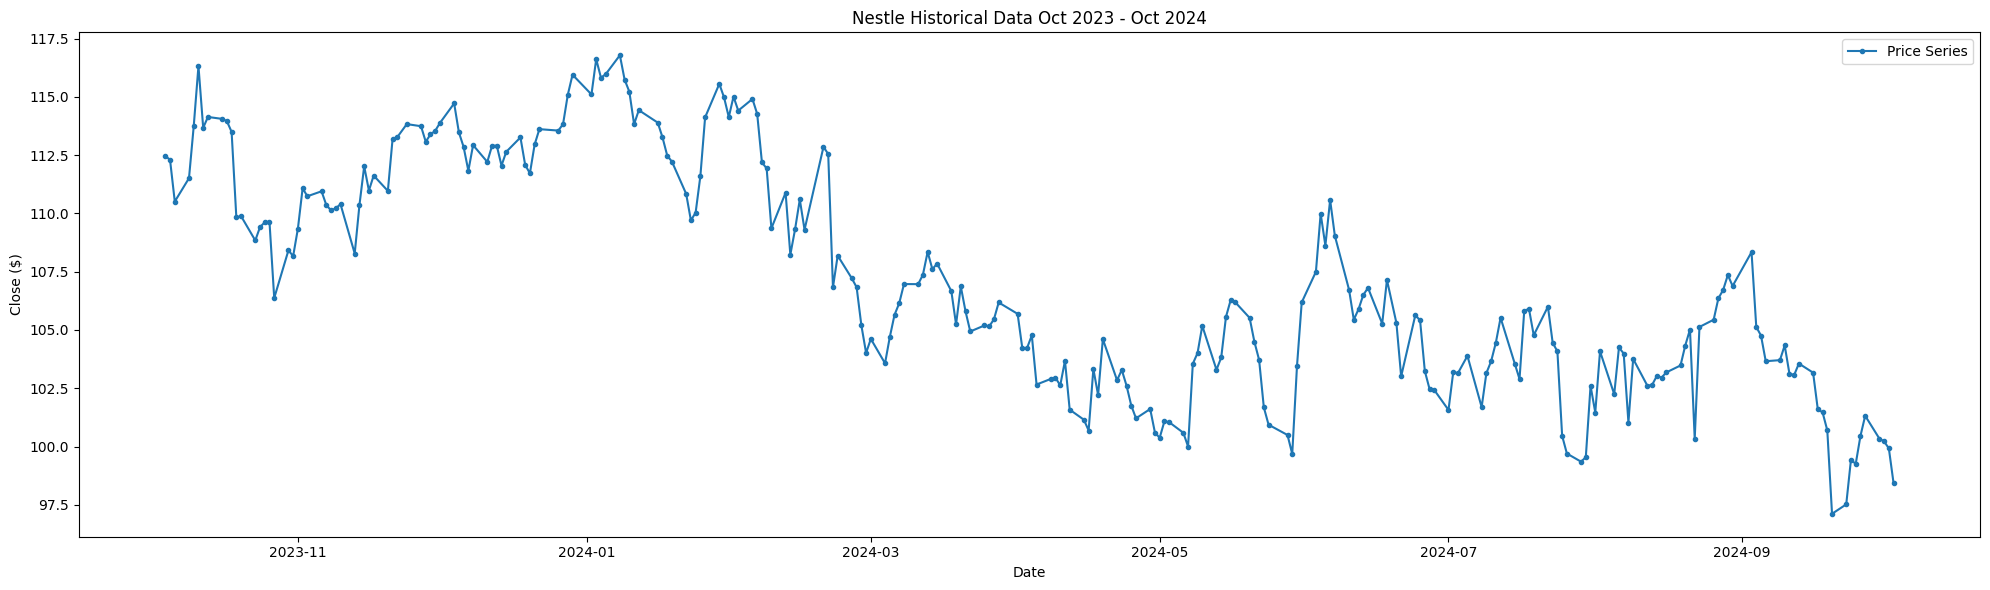

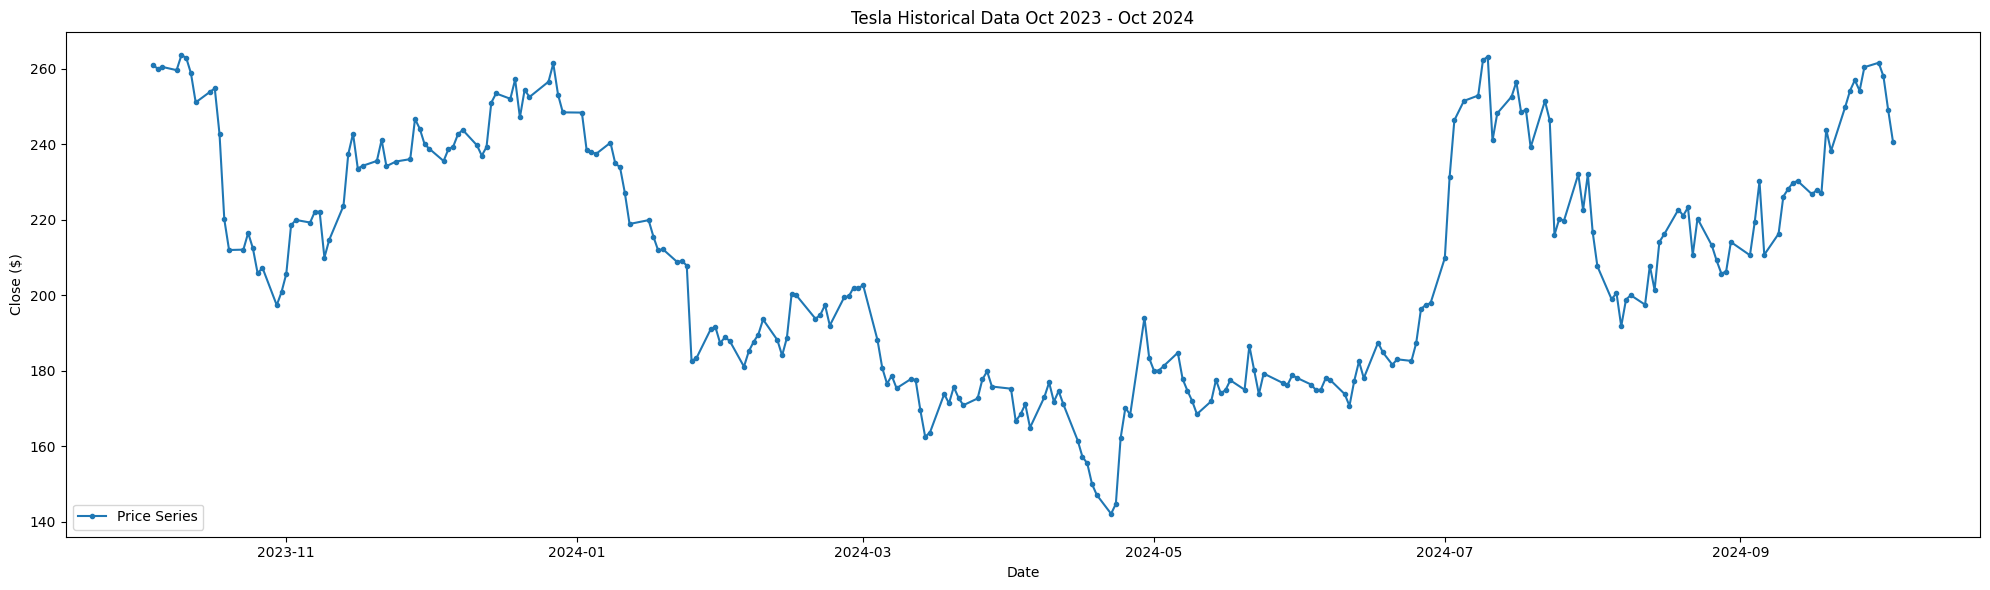

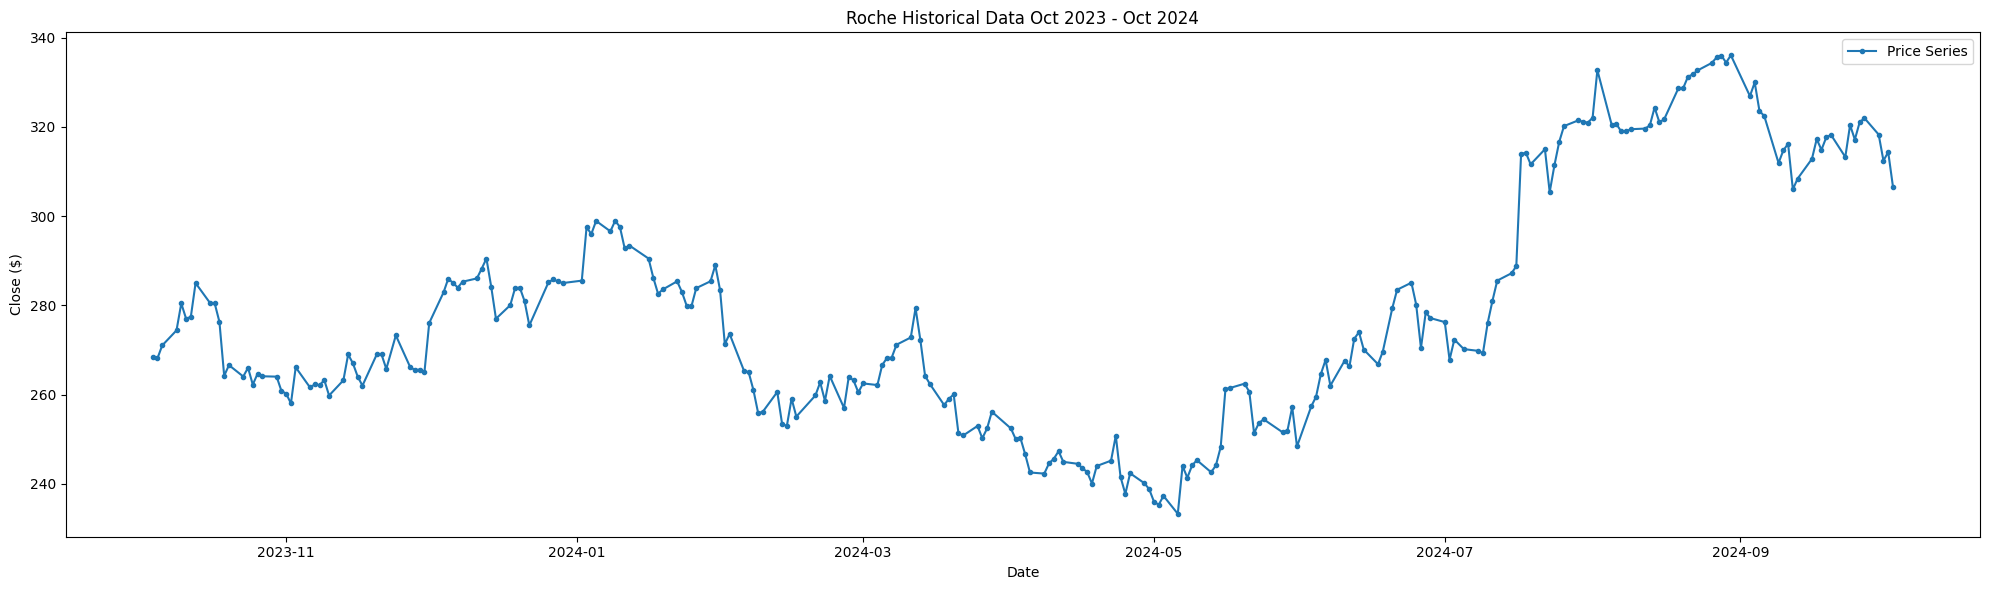

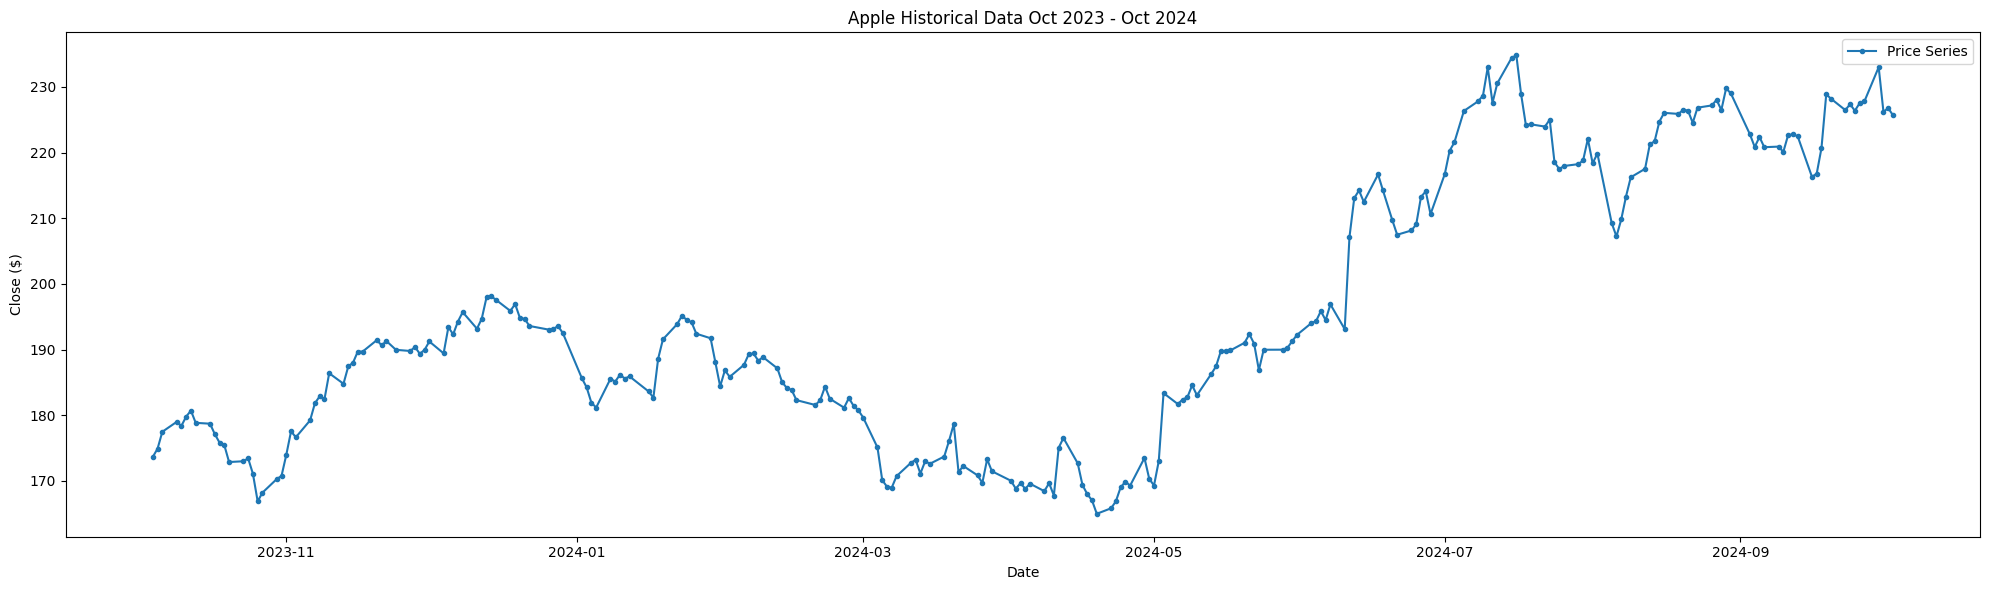

In [ ]:
#Plot the data
def plot_data(file_path, stock_name=""):
    df = pd.read_csv(file_path)

    x = df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')  # X-axis values
    y = df['Close']  # Y-axis values

    # Create a line plot
    plt.figure(figsize=(20, 6))
    plt.plot(x, y, marker='o', markersize=3, label='Price Series')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Close ($)')
    default_title = 'Historical Data Oct 2023 - Oct 2024'
    plt.title(f"{stock_name} {default_title}")

    # Show legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_data(file_path_nestle, "Nestle")
plot_data(file_path_tesla, "Tesla")
plot_data(file_path_roche, "Roche")
plot_data(file_path_apple, "Apple")

In [ ]:
#Create Head and Shoulder Pattern detector
def hs_pattern_detector(ys, w, pflag, name):
    """
    Identifies potential Head and Shoulders (HS) patterns in a price series and plots the results.

    Parameters:
    ys (numpy array): Price series.
    w (int): Size of the rolling window.
    pflag (int): Flag for plotting (1 for plotting, 0 for no plots).

    Returns:
    PATTERNS (dict): Contains identified HS patterns in 'NORMAL' and 'INVERSE' forms.
    """
    # Data preparation
    l = len(ys)
    peaks, bottoms = rw(ys, w, 1, name)  # Identify peaks and bottoms using rolling window
    print(f"Peaks detected: {peaks}")
    print(f"Bottoms detected: {bottoms}")

    # Combine peaks and bottoms with labels (1 for peaks, 2 for bottoms)
    P_Indx = np.column_stack((peaks[:, 1], np.ones(len(peaks))))  # Add a column of 1s for peaks
    B_Indx = np.column_stack((bottoms[:, 1], 2 * np.ones(len(bottoms))))  # Add a column of 2s for bottoms

    # Merge and sort by time (x-axis index)
    PB_Indx = np.vstack((P_Indx, B_Indx))
    PB_Indx = PB_Indx[PB_Indx[:, 0].argsort()]  # Sort by time (x-index)

    m = len(PB_Indx)  # Number of combined peaks and bottoms
    Pot = {
        'Normal': np.array([1, 2, 1, 2, 1]),  # Normal HS pattern (Peak, Bottom, Peak, Bottom, Peak)
        'Inverse': np.array([2, 1, 2, 1, 2]),  # Inverse HS pattern (Bottom, Peak, Bottom, Peak, Bottom)
        'Index': np.zeros(m)  # To store potential pattern indexes
    }

    # Check for potential HS patterns in the combined peaks and bottoms
    for i in range(m - 4):
        if np.array_equal(PB_Indx[i:i + 5, 1], Pot['Normal']):
            Pot['Index'][i + 4] = 1  # Identified a potential Normal HS pattern
        elif np.array_equal(PB_Indx[i:i + 5, 1], Pot['Inverse']):
            Pot['Index'][i + 4] = 2  # Identified a potential Inverse HS pattern

    # Indices of potential Normal and Inverse patterns
    PNidx = np.where(Pot['Index'] == 1)[0]  # Normal patterns
    PIidx = np.where(Pot['Index'] == 2)[0]  # Inverse patterns

    # Initialize the dictionary to store patterns
    PATTERNS = {'NORMAL': {}, 'INVERSE': {}}
    PATTERNS['NORMAL']['Numberofnormals'] = 0
    PATTERNS['INVERSE']['Numberofinverses'] = 0

    # Detecting Normal HS patterns
    mn = len(PNidx)
    if mn > 0:
        Pot['Normalcases'] = {'Idx': np.zeros(mn)}  # To store potential Normal HS patterns
        for i in range(mn):
            PerCase = np.zeros((5, 3))  # To hold x, y coordinates for each pattern
            PerCase[:, [0, 1]] = PB_Indx[PNidx[i] - 4:PNidx[i] + 1, :]  # Get 5 points (peak-bottom-peak-bottom-peak)
            PerCase[:, 2] = ys[PerCase[:, 0].astype(int)]  # Map the y-values (price) to the x-values (index)

            # Validate the HS pattern conditions
            if (PerCase[2, 2] > max(PerCase[[0, 4], 2]) and
                    PerCase[0, 2] >= 0.5 * sum(PerCase[[3, 4], 2]) and
                    PerCase[4, 2] >= 0.5 * sum(PerCase[[0, 1], 2]) and
                    (PerCase[2, 0] - PerCase[0, 0] < 2.5 * (PerCase[4, 0] - PerCase[2, 0])) and
                    (PerCase[4, 0] - PerCase[2, 0] < 2.5 * (PerCase[2, 0] - PerCase[0, 0]))):
                Pot['Normalcases']['Idx'][i] = 1  # Mark the case as a valid HS pattern
                Pot['Normalcases'].setdefault('Percases', {})[i] = PerCase  # Store the pattern

        # Finalize valid patterns
        mnn = int(np.sum(Pot['Normalcases']['Idx']))
        Pot['Normalcases']['Idx2'] = np.where(Pot['Normalcases']['Idx'] == 1)[0]  # Get valid pattern indices

        # Validate and calculate important properties of each pattern
        j = 0
        PATTERNS['NORMAL'] = {
            'Points': [],
            'Necklines': [],
            'Breakpoints': [],
            'Widths': [],
            'Heights': [],
            'TL': [],
            'PT': [],
            'Numberofnormals': 0
        }

        for i in range(mnn):
            NPerCase = Pot['Normalcases']['Percases'][Pot['Normalcases']['Idx2'][i]]
            Timelimit = NPerCase[4, 0] + (NPerCase[4, 0] - NPerCase[0, 0])  # Time limit to validate
            Beta = (NPerCase[3, 2] - NPerCase[1, 2]) / (NPerCase[3, 0] - NPerCase[1, 0])  # Slope of neckline
            Alpha = NPerCase[1, 2] - Beta * NPerCase[1, 0]  # Intercept of neckline

            # Check if the pattern fits within the time limits
            if Timelimit <= l:
                OU = np.arange(NPerCase[4, 0] + 1, Timelimit).astype(int)
            else:
                OU = np.arange(NPerCase[4, 0] + 1, l).astype(int)

            OU = np.vstack((OU, ys[OU]))  # Append y-values for those points
            OU = np.vstack((OU, Beta * OU[0, :] + Alpha))  # Calculate the neckline
            OU = np.vstack((OU, OU[1, :] - OU[2, :]))  # Find the difference (for breakpoints)
            Breakpoint = np.where(OU[3, :] < 0)[0]  # Identify the breakpoint

            if Breakpoint.size > 0:
                j += 1
                PATTERNS['NORMAL']['Points'].append(NPerCase)
                PATTERNS['NORMAL']['Necklines'].append([Alpha, Beta])  # Store neckline slope and intercept
                PATTERNS['NORMAL']['Breakpoints'].append(
                    [OU[0, Breakpoint[0]], ys[int(OU[0, Breakpoint[0]])]])  # Breakpoint
                PATTERNS['NORMAL']['Widths'].append(NPerCase[3, 0] - NPerCase[1, 0])  # Width of the pattern
                PATTERNS['NORMAL']['Heights'].append(
                    NPerCase[2, 2] - (Beta * NPerCase[2, 0] + Alpha))  # Height of the pattern

                # Calculate the target price (TL: time limit, PT: potential target price)
                PATTERNS['NORMAL']['TL'].append(
                    PATTERNS['NORMAL']['Breakpoints'][j - 1][0] + PATTERNS['NORMAL']['Widths'][j - 1])

                # Fixing line_inter call by ensuring A and B are 2D arrays
                A = np.array([[NPerCase[1, 0], NPerCase[1, 2]], [NPerCase[3, 0], NPerCase[3, 2]]])  # Neckline points
                B = np.array([[PATTERNS['NORMAL']['Breakpoints'][j - 1][0] - 1,
                               ys[int(PATTERNS['NORMAL']['Breakpoints'][j - 1][0] - 1)]]])
                B = np.vstack((B, [PATTERNS['NORMAL']['Breakpoints'][j - 1][0],
                                   ys[int(PATTERNS['NORMAL']['Breakpoints'][j - 1][0])]]))  # Extending B to 2 points

                _, ystar = line_inter(A, B)  # Calculate intersection
                PATTERNS['NORMAL']['PT'].append(ystar - PATTERNS['NORMAL']['Heights'][j - 1])  # Potential target price

        PATTERNS['NORMAL']['Numberofnormals'] = j  # Store the number of valid normal patterns

    # Similar process can be applied for INVERSE patterns

        # Detecting Inverse HS patterns
        mi = len(PIidx)
        if mi > 0:
            Pot['Inversecases'] = {'Idx': np.zeros(mi)}  # To store potential Inverse HS patterns
            for i in range(mi):
                PerCase = np.zeros((5, 3))  # To hold x, y coordinates for each pattern
                PerCase[:, [0, 1]] = PB_Indx[PIidx[i] - 4:PIidx[i] + 1,
                                     :]  # Get 5 points (bottom-peak-bottom-peak-bottom)
                PerCase[:, 2] = ys[PerCase[:, 0].astype(int)]  # Map the y-values (price) to the x-values (index)

                # Validate the Inverse HS pattern conditions
                if (PerCase[2, 2] < min(PerCase[[0, 4], 2]) and
                        PerCase[0, 2] <= 0.5 * sum(PerCase[[3, 4], 2]) and
                        PerCase[4, 2] <= 0.5 * sum(PerCase[[0, 1], 2]) and
                        (PerCase[2, 0] - PerCase[0, 0] < 2.5 * (PerCase[4, 0] - PerCase[2, 0])) and
                        (PerCase[4, 0] - PerCase[2, 0] < 2.5 * (PerCase[2, 0] - PerCase[0, 0]))):
                    Pot['Inversecases']['Idx'][i] = 1  # Mark the case as a valid inverse HS pattern
                    Pot['Inversecases'].setdefault('Percases', {})[i] = PerCase  # Store the pattern

            # Finalize valid patterns
            mii = int(np.sum(Pot['Inversecases']['Idx']))
            Pot['Inversecases']['Idx2'] = np.where(Pot['Inversecases']['Idx'] == 1)[0]  # Get valid pattern indices

            # Validate and calculate important properties of each pattern
            j = 0
            PATTERNS['INVERSE'] = {
                'Points': [],
                'Necklines': [],
                'Breakpoints': [],
                'Widths': [],
                'Heights': [],
                'TL': [],
                'PT': [],
                'Numberofinverses': 0
            }

            for i in range(mii):
                NPerCase = Pot['Inversecases']['Percases'][Pot['Inversecases']['Idx2'][i]]
                Timelimit = NPerCase[4, 0] + (NPerCase[4, 0] - NPerCase[0, 0])  # Time limit to validate
                Beta = (NPerCase[3, 2] - NPerCase[1, 2]) / (NPerCase[3, 0] - NPerCase[1, 0])  # Slope of neckline
                Alpha = NPerCase[1, 2] - Beta * NPerCase[1, 0]  # Intercept of neckline

                # Check if the pattern fits within the time limits
                if Timelimit <= l:
                    OU = np.arange(NPerCase[4, 0] + 1, Timelimit).astype(int)
                else:
                    OU = np.arange(NPerCase[4, 0] + 1, l).astype(int)

                OU = np.vstack((OU, ys[OU]))  # Append y-values for those points
                OU = np.vstack((OU, Beta * OU[0, :] + Alpha))  # Calculate the neckline
                OU = np.vstack((OU, OU[1, :] - OU[2, :]))  # Find the difference (for breakpoints)
                Breakpoint = np.where(OU[3, :] > 0)[0]  # Identify the breakpoint

                if Breakpoint.size > 0:
                    j += 1
                    PATTERNS['INVERSE']['Points'].append(NPerCase)
                    PATTERNS['INVERSE']['Necklines'].append([Alpha, Beta])  # Store neckline slope and intercept
                    PATTERNS['INVERSE']['Breakpoints'].append(
                        [OU[0, Breakpoint[0]], ys[int(OU[0, Breakpoint[0]])]])  # Breakpoint
                    PATTERNS['INVERSE']['Widths'].append(NPerCase[3, 0] - NPerCase[1, 0])  # Width of the pattern
                    PATTERNS['INVERSE']['Heights'].append(
                        (Beta * NPerCase[2, 0] + Alpha) - NPerCase[2, 2])  # Height of the pattern

                    # Calculate the target price (TL: time limit, PT: potential target price)
                    PATTERNS['INVERSE']['TL'].append(
                        PATTERNS['INVERSE']['Breakpoints'][j - 1][0] + PATTERNS['INVERSE']['Widths'][j - 1])

                    # Fixing line_inter call by ensuring A and B are 2D arrays
                    A = np.array(
                        [[NPerCase[1, 0], NPerCase[1, 2]], [NPerCase[3, 0], NPerCase[3, 2]]])  # Neckline points
                    B = np.array([[PATTERNS['INVERSE']['Breakpoints'][j - 1][0] - 1,
                                   ys[int(PATTERNS['INVERSE']['Breakpoints'][j - 1][0] - 1)]]])
                    B = np.vstack((B, [PATTERNS['INVERSE']['Breakpoints'][j - 1][0],
                                       ys[int(
                                           PATTERNS['INVERSE']['Breakpoints'][j - 1][0])]]))  # Extending B to 2 points

                    _, ystar = line_inter(A, B)  # Calculate intersection
                    PATTERNS['INVERSE']['PT'].append(
                        ystar + PATTERNS['INVERSE']['Heights'][j - 1])  # Potential target price

            PATTERNS['INVERSE']['Numberofinverses'] = j  # Store the number of valid inverse patterns

    # Plotting if required
    if pflag == 1 and (PATTERNS['NORMAL']['Numberofnormals'] > 0 or PATTERNS['INVERSE']['Numberofinverses'] > 0):
        plt.plot(ys, label="Price Series")  # Plot the original price series

        # Plotting Normal HS patterns
        if PATTERNS['NORMAL']['Numberofnormals'] > 0:
            for i in range(PATTERNS['NORMAL']['Numberofnormals']):
                # Plot the points of the pattern
                plt.plot(PATTERNS['NORMAL']['Points'][i][:, 0], PATTERNS['NORMAL']['Points'][i][:, 2], 'r*-',
                         label="Normal HS Pattern" if i == 0 else "")  # Label only once
                # Plot the breakpoint
                plt.plot(PATTERNS['NORMAL']['Breakpoints'][i][0], PATTERNS['NORMAL']['Breakpoints'][i][1], 'rv',
                         label="Normal Breakpoint" if i == 0 else "")

                # Plot the neckline using the calculated slope (Beta) and intercept (Alpha)
                neckline_start_x = PATTERNS['NORMAL']['Points'][i][1, 0]  # Start of the neckline (first bottom point)
                neckline_end_x = PATTERNS['NORMAL']['Points'][i][3, 0]  # End of the neckline (second bottom point)
                Beta = PATTERNS['NORMAL']['Necklines'][i][1]  # Slope (Beta)
                Alpha = PATTERNS['NORMAL']['Necklines'][i][0]  # Intercept (Alpha)
                neckline_start_y = Beta * neckline_start_x + Alpha  # y = mx + c (start y-coordinate)
                neckline_end_y = Beta * neckline_end_x + Alpha  # y = mx + c (end y-coordinate)
                plt.plot([neckline_start_x, neckline_end_x], [neckline_start_y, neckline_end_y], 'g--',
                         label="Normal Neckline" if i == 0 else "")

        # Plotting Inverse HS patterns
        if PATTERNS['INVERSE']['Numberofinverses'] > 0:
            for i in range(PATTERNS['INVERSE']['Numberofinverses']):
                # Plot the points of the pattern
                plt.plot(PATTERNS['INVERSE']['Points'][i][:, 0], PATTERNS['INVERSE']['Points'][i][:, 2], 'b*-',
                         label="Inverse HS Pattern" if i == 0 else "")  # Label only once
                # Plot the breakpoint
                plt.plot(PATTERNS['INVERSE']['Breakpoints'][i][0], PATTERNS['INVERSE']['Breakpoints'][i][1], 'bv',
                         label="Inverse Breakpoint" if i == 0 else "")

                # Plot the neckline using the calculated slope (Beta) and intercept (Alpha)
                neckline_start_x = PATTERNS['INVERSE']['Points'][i][1, 0]  # Start of the neckline (first peak point)
                neckline_end_x = PATTERNS['INVERSE']['Points'][i][3, 0]  # End of the neckline (second peak point)
                Beta = PATTERNS['INVERSE']['Necklines'][i][1]  # Slope (Beta)
                Alpha = PATTERNS['INVERSE']['Necklines'][i][0]  # Intercept (Alpha)
                neckline_start_y = Beta * neckline_start_x + Alpha  # y = mx + c (start y-coordinate)
                neckline_end_y = Beta * neckline_end_x + Alpha  # y = mx + c (end y-coordinate)
                plt.plot([neckline_start_x, neckline_end_x], [neckline_start_y, neckline_end_y], 'm--',
                         label="Inverse Neckline" if i == 0 else "")

        # Display the legend
        plt.legend(loc="upper left", fontsize="x-small")
        default_title = 'HS Pattern'
        plt.title(f"{name} {default_title}")
        plt.legend()
        plt.show()
        plt.show()

    return PATTERNS


def line_inter(A, B):
    """
    Finds the intersection point of two lines defined by points A and B.

    Parameters:
    A, B (numpy arrays): Each should be 2x2 arrays representing two points per line.

    Returns:
    tstar, ystar (float): Intersection point (x, y) of the two lines.
    """
    A = np.asarray(A)
    B = np.asarray(B)

    if A.shape != (2, 2) or B.shape != (2, 2):
        raise ValueError("Both A and B must be 2x2 arrays representing two points each.")

    # Calculate slopes and intercepts of both lines
    S1 = (A[1, 1] - A[0, 1]) / (A[1, 0] - A[0, 0])  # Slope of line A
    S2 = (B[1, 1] - B[0, 1]) / (B[1, 0] - B[0, 0])  # Slope of line B
    C1 = A[0, 1] - S1 * A[0, 0]  # Intercept of line A
    C2 = B[0, 1] - S2 * B[0, 0]  # Intercept of line B

    # Calculate intersection
    tstar = (C2 - C1) / (S1 - S2)  # x-coordinate of intersection
    ystar = S1 * tstar + C1  # y-coordinate of intersection

    return tstar, ystar


def rw(ys, w, pflag, name):
    """
    Identifies peaks and bottoms of a price series using a rolling window.

    Parameters:
    ys (numpy array): Price series.
    w (int): Rolling window size.
    pflag (int): Flag for plotting (1 for plotting, 0 for no plots).

    Returns:
    Peaks, Bottoms (numpy arrays): Coordinates of detected peaks and bottoms.
    """
    l = len(ys)
    Peaks_Bottoms = np.zeros((l, 2))  # Array to store peaks and bottoms

    # Loop through the series to identify peaks and bottoms
    for i in range(w, l - w):
        if ys[i] > np.max(ys[i - w:i]) and ys[i] > np.max(ys[i + 1:i + w + 1]):
            Peaks_Bottoms[i, 0] = 1  # Identified peak
        if ys[i] < np.min(ys[i - w:i]) and ys[i] < np.min(ys[i + 1:i + w + 1]):
            Peaks_Bottoms[i, 1] = 1  # Identified bottom

    # Extract the indices of peaks and bottoms
    P_Indx = np.where(Peaks_Bottoms[:, 0] == 1)[0]
    B_Indx = np.where(Peaks_Bottoms[:, 1] == 1)[0]

    # Create arrays for peaks and bottoms with x (index) and y (price) values
    Peaks = np.column_stack((ys[P_Indx], P_Indx))
    Bottoms = np.column_stack((ys[B_Indx], B_Indx))

    # Plotting if requested
    if pflag == 1:
        plt.plot(ys)
        plt.plot(Peaks[:, 1], Peaks[:, 0], 'ro', label='Peaks')
        plt.plot(Bottoms[:, 1], Bottoms[:, 0], 'r*', label='Bottoms')
        default_title = 'HS Pattern'
        plt.title(f"{name} {default_title}")
        plt.legend()
        plt.show()

    return Peaks, Bottoms

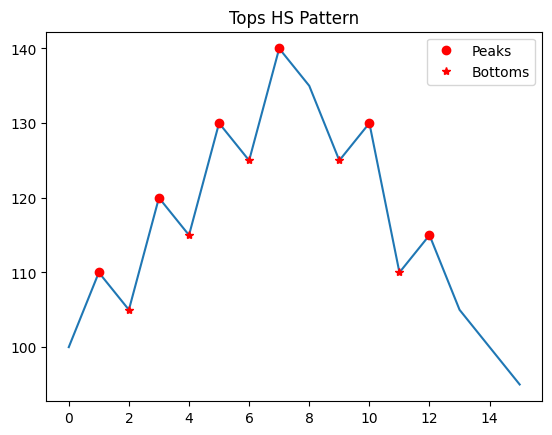

Peaks detected: [[110   1]
 [120   3]
 [130   5]
 [140   7]
 [130  10]
 [115  12]]
Bottoms detected: [[105   2]
 [115   4]
 [125   6]
 [125   9]
 [110  11]]


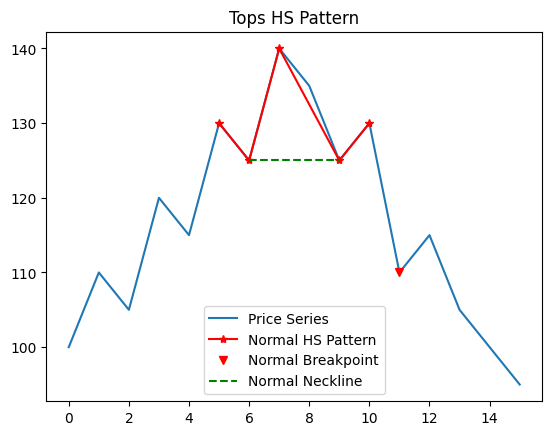

Identified Head and Shoulders Patterns (Normal Form): {'Points': [array([[  5.,   1., 130.],
       [  6.,   2., 125.],
       [  7.,   1., 140.],
       [  9.,   2., 125.],
       [ 10.,   1., 130.]])], 'Necklines': [[125.0, 0.0]], 'Breakpoints': [[11.0, 110]], 'Widths': [3.0], 'Heights': [15.0], 'TL': [14.0], 'PT': [110.0], 'Numberofnormals': 1}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [], 'Necklines': [], 'Breakpoints': [], 'Widths': [], 'Heights': [], 'TL': [], 'PT': [], 'Numberofinverses': 0}


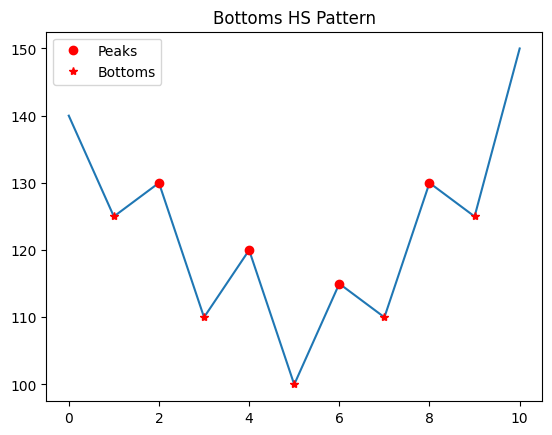

Peaks detected: [[130   2]
 [120   4]
 [115   6]
 [130   8]]
Bottoms detected: [[125   1]
 [110   3]
 [100   5]
 [110   7]
 [125   9]]


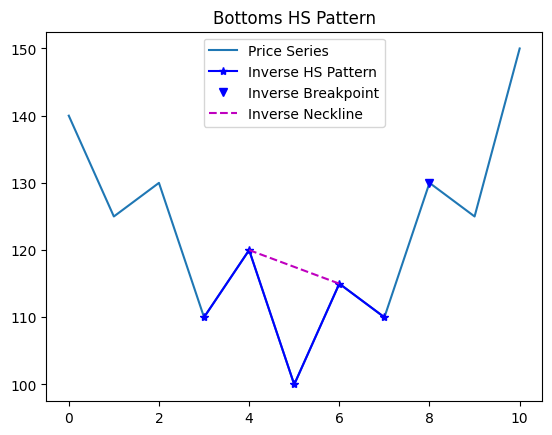

Identified Head and Shoulders Patterns (Normal Form): {'Points': [], 'Necklines': [], 'Breakpoints': [], 'Widths': [], 'Heights': [], 'TL': [], 'PT': [], 'Numberofnormals': 0}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[  3.,   2., 110.],
       [  4.,   1., 120.],
       [  5.,   2., 100.],
       [  6.,   1., 115.],
       [  7.,   2., 110.]])], 'Necklines': [[130.0, -2.5]], 'Breakpoints': [[8.0, 130]], 'Widths': [2.0], 'Heights': [17.5], 'TL': [10.0], 'PT': [129.72222222222223], 'Numberofinverses': 1}


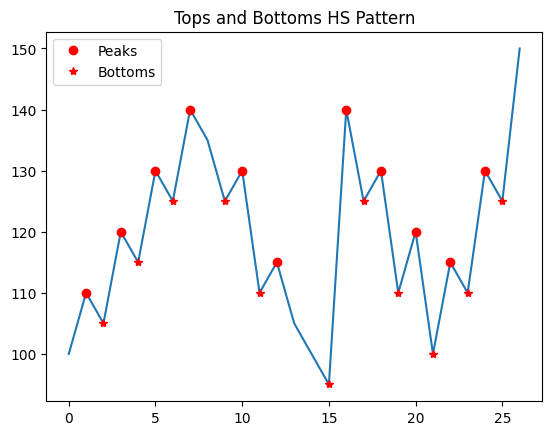

Peaks detected: [[110   1]
 [120   3]
 [130   5]
 [140   7]
 [130  10]
 [115  12]
 [140  16]
 [130  18]
 [120  20]
 [115  22]
 [130  24]]
Bottoms detected: [[105   2]
 [115   4]
 [125   6]
 [125   9]
 [110  11]
 [ 95  15]
 [125  17]
 [110  19]
 [100  21]
 [110  23]
 [125  25]]


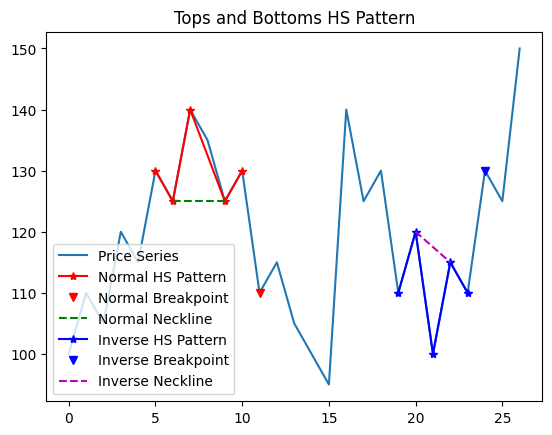

Identified Head and Shoulders Patterns (Normal Form): {'Points': [array([[  5.,   1., 130.],
       [  6.,   2., 125.],
       [  7.,   1., 140.],
       [  9.,   2., 125.],
       [ 10.,   1., 130.]])], 'Necklines': [[125.0, 0.0]], 'Breakpoints': [[11.0, 110]], 'Widths': [3.0], 'Heights': [15.0], 'TL': [14.0], 'PT': [110.0], 'Numberofnormals': 1}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[ 19.,   2., 110.],
       [ 20.,   1., 120.],
       [ 21.,   2., 100.],
       [ 22.,   1., 115.],
       [ 23.,   2., 110.]])], 'Necklines': [[170.0, -2.5]], 'Breakpoints': [[24.0, 130]], 'Widths': [2.0], 'Heights': [17.5], 'TL': [26.0], 'PT': [129.72222222222223], 'Numberofinverses': 1}


In [ ]:
#Test detector with example data
def test_examples(test_data, name):
    w = 1  # Rolling window size
    pflag = 1  # Set to 1 to plot the series
    patterns = hs_pattern_detector(test_data, w, pflag, name)  # Detect patterns
    # Print the result
    print("Identified Head and Shoulders Patterns (Normal Form):", patterns['NORMAL'])
    print("Identified Head and Shoulders Patterns (Inverse Form):", patterns['INVERSE'])

# Example usage
tops = np.array([100, 110, 105, 120, 115, 130, 125, 140, 135, 125, 130, 110, 115, 105, 100, 95])
bottoms = np.array([140, 125, 130, 110, 120, 100, 115, 110, 130, 125, 150])
tops_and_bottoms = np.array([100, 110, 105, 120, 115, 130, 125, 140, 135, 125, 130, 110, 115, 105, 100, 95, 140, 125, 130, 110, 120, 100, 115, 110, 130, 125, 150])


test_examples(tops, "Tops")
test_examples(bottoms, "Bottoms")
test_examples(tops_and_bottoms, "Tops and Bottoms")

In [ ]:
#Adjust the code the accomodate imported real data
def hs_pattern(ys, w, pflag, dates, stock_name):
    """
    Identifies potential Head and Shoulders (HS) patterns in a price series and plots the results.

    Parameters:
    ys (numpy array): Price series.
    w (int): Size of the rolling window.
    pflag (int): Flag for plotting (1 for plotting, 0 for no plots).

    Returns:
    PATTERNS (dict): Contains identified HS patterns in 'NORMAL' and 'INVERSE' forms.
    """
    # Data preparation
    l = len(ys)
    peaks, bottoms = rw(dates, ys, w, 1, stock_name)  # Identify peaks and bottoms using rolling window
    print(f"Peaks detected: {peaks}")
    print(f"Bottoms detected: {bottoms}")

    # Combine peaks and bottoms with labels (1 for peaks, 2 for bottoms)
    P_Indx = np.column_stack((peaks[:, 1], np.ones(len(peaks))))  # Add a column of 1s for peaks
    B_Indx = np.column_stack((bottoms[:, 1], 2 * np.ones(len(bottoms))))  # Add a column of 2s for bottoms

    # Merge and sort by time (x-axis index)
    PB_Indx = np.vstack((P_Indx, B_Indx))
    PB_Indx = PB_Indx[PB_Indx[:, 0].argsort()]  # Sort by time (x-index)

    m = len(PB_Indx)  # Number of combined peaks and bottoms
    Pot = {
        'Normal': np.array([1, 2, 1, 2, 1]),  # Normal HS pattern (Peak, Bottom, Peak, Bottom, Peak)
        'Inverse': np.array([2, 1, 2, 1, 2]),  # Inverse HS pattern (Bottom, Peak, Bottom, Peak, Bottom)
        'Index': np.zeros(m)  # To store potential pattern indexes
    }

    # Check for potential HS patterns in the combined peaks and bottoms
    for i in range(m - 4):
        if np.array_equal(PB_Indx[i:i + 5, 1], Pot['Normal']):
            Pot['Index'][i + 4] = 1  # Identified a potential Normal HS pattern
        elif np.array_equal(PB_Indx[i:i + 5, 1], Pot['Inverse']):
            Pot['Index'][i + 4] = 2  # Identified a potential Inverse HS pattern

    # Indices of potential Normal and Inverse patterns
    PNidx = np.where(Pot['Index'] == 1)[0]  # Normal patterns
    PIidx = np.where(Pot['Index'] == 2)[0]  # Inverse patterns

    # Initialize the dictionary to store patterns
    PATTERNS = {'NORMAL': {}, 'INVERSE': {}}
    PATTERNS['NORMAL']['Numberofnormals'] = 0
    PATTERNS['INVERSE']['Numberofinverses'] = 0

    # Detecting Normal HS patterns
    mn = len(PNidx)
    if mn > 0:
        Pot['Normalcases'] = {'Idx': np.zeros(mn)}  # To store potential Normal HS patterns
        for i in range(mn):
            PerCase = np.zeros((5, 3))  # To hold x, y coordinates for each pattern
            PerCase[:, [0, 1]] = PB_Indx[PNidx[i] - 4:PNidx[i] + 1, :]  # Get 5 points (peak-bottom-peak-bottom-peak)
            PerCase[:, 2] = ys[PerCase[:, 0].astype(int)]  # Map the y-values (price) to the x-values (index)

            # Validate the HS pattern conditions
            if (PerCase[2, 2] > max(PerCase[[0, 4], 2]) and
                    PerCase[0, 2] >= 0.5 * sum(PerCase[[3, 4], 2]) and
                    PerCase[4, 2] >= 0.5 * sum(PerCase[[0, 1], 2]) and
                    (PerCase[2, 0] - PerCase[0, 0] < 2.5 * (PerCase[4, 0] - PerCase[2, 0])) and
                    (PerCase[4, 0] - PerCase[2, 0] < 2.5 * (PerCase[2, 0] - PerCase[0, 0]))):
                Pot['Normalcases']['Idx'][i] = 1  # Mark the case as a valid HS pattern
                Pot['Normalcases'].setdefault('Percases', {})[i] = PerCase  # Store the pattern

        # Finalize valid patterns
        mnn = int(np.sum(Pot['Normalcases']['Idx']))
        Pot['Normalcases']['Idx2'] = np.where(Pot['Normalcases']['Idx'] == 1)[0]  # Get valid pattern indices

        # Validate and calculate important properties of each pattern
        j = 0
        PATTERNS['NORMAL'] = {
            'Points': [],
            'Necklines': [],
            'Breakpoints': [],
            'Widths': [],
            'Heights': [],
            'TL': [],
            'PT': [],
            'Numberofnormals': 0
        }

        for i in range(mnn):
            NPerCase = Pot['Normalcases']['Percases'][Pot['Normalcases']['Idx2'][i]]
            Timelimit = NPerCase[4, 0] + (NPerCase[4, 0] - NPerCase[0, 0])  # Time limit to validate
            Beta = (NPerCase[3, 2] - NPerCase[1, 2]) / (NPerCase[3, 0] - NPerCase[1, 0])  # Slope of neckline
            Alpha = NPerCase[1, 2] - Beta * NPerCase[1, 0]  # Intercept of neckline

            # Check if the pattern fits within the time limits
            if Timelimit <= l:
                OU = np.arange(NPerCase[4, 0] + 1, Timelimit).astype(int)
            else:
                OU = np.arange(NPerCase[4, 0] + 1, l).astype(int)

            OU = np.vstack((OU, ys[OU]))  # Append y-values for those points
            OU = np.vstack((OU, Beta * OU[0, :] + Alpha))  # Calculate the neckline
            OU = np.vstack((OU, OU[1, :] - OU[2, :]))  # Find the difference (for breakpoints)
            Breakpoint = np.where(OU[3, :] < 0)[0]  # Identify the breakpoint

            if Breakpoint.size > 0:
                j += 1
                PATTERNS['NORMAL']['Points'].append(NPerCase)
                PATTERNS['NORMAL']['Necklines'].append([Alpha, Beta])  # Store neckline slope and intercept
                PATTERNS['NORMAL']['Breakpoints'].append(
                    [OU[0, Breakpoint[0]], ys[int(OU[0, Breakpoint[0]])]])  # Breakpoint
                PATTERNS['NORMAL']['Widths'].append(NPerCase[3, 0] - NPerCase[1, 0])  # Width of the pattern
                PATTERNS['NORMAL']['Heights'].append(
                    NPerCase[2, 2] - (Beta * NPerCase[2, 0] + Alpha))  # Height of the pattern

                # Calculate the target price (TL: time limit, PT: potential target price)
                PATTERNS['NORMAL']['TL'].append(
                    PATTERNS['NORMAL']['Breakpoints'][j - 1][0] + PATTERNS['NORMAL']['Widths'][j - 1])

                # Fixing line_inter call by ensuring A and B are 2D arrays
                A = np.array([[NPerCase[1, 0], NPerCase[1, 2]], [NPerCase[3, 0], NPerCase[3, 2]]])  # Neckline points
                B = np.array([[PATTERNS['NORMAL']['Breakpoints'][j - 1][0] - 1,
                               ys[int(PATTERNS['NORMAL']['Breakpoints'][j - 1][0] - 1)]]])
                B = np.vstack((B, [PATTERNS['NORMAL']['Breakpoints'][j - 1][0],
                                   ys[int(PATTERNS['NORMAL']['Breakpoints'][j - 1][0])]]))  # Extending B to 2 points

                _, ystar = line_inter(A, B)  # Calculate intersection
                PATTERNS['NORMAL']['PT'].append(ystar - PATTERNS['NORMAL']['Heights'][j - 1])  # Potential target price

        PATTERNS['NORMAL']['Numberofnormals'] = j  # Store the number of valid normal patterns

    # Similar process can be applied for INVERSE patterns
    mi = len(PIidx)
    if mi > 0:
        Pot['Inversecases'] = {'Idx': np.zeros(mi)}  # To store potential Inverse HS patterns
        for i in range(mi):
            PerCase = np.zeros((5, 3))  # To hold x, y coordinates for each pattern
            PerCase[:, [0, 1]] = PB_Indx[PIidx[i] - 4:PIidx[i] + 1, :]  # Get 5 points (bottom-peak-bottom-peak-bottom)
            PerCase[:, 2] = ys[PerCase[:, 0].astype(int)]  # Map the y-values (price) to the x-values (index)

            # Validate the Inverse HS pattern conditions
            if (PerCase[2, 2] < min(PerCase[[0, 4], 2]) and
                    PerCase[0, 2] <= 0.5 * sum(PerCase[[3, 4], 2]) and
                    PerCase[4, 2] <= 0.5 * sum(PerCase[[0, 1], 2]) and
                    (PerCase[2, 0] - PerCase[0, 0] < 2.5 * (PerCase[4, 0] - PerCase[2, 0])) and
                    (PerCase[4, 0] - PerCase[2, 0] < 2.5 * (PerCase[2, 0] - PerCase[0, 0]))):
                Pot['Inversecases']['Idx'][i] = 1  # Mark the case as a valid inverse HS pattern
                Pot['Inversecases'].setdefault('Percases', {})[i] = PerCase  # Store the pattern

        # Finalize valid patterns
        mii = int(np.sum(Pot['Inversecases']['Idx']))
        Pot['Inversecases']['Idx2'] = np.where(Pot['Inversecases']['Idx'] == 1)[0]  # Get valid pattern indices

        # Validate and calculate important properties of each pattern
        j = 0
        PATTERNS['INVERSE'] = {
            'Points': [],
            'Necklines': [],
            'Breakpoints': [],
            'Widths': [],
            'Heights': [],
            'TL': [],
            'PT': [],
            'Numberofinverses': 0
        }

        for i in range(mii):
            NPerCase = Pot['Inversecases']['Percases'][Pot['Inversecases']['Idx2'][i]]
            Timelimit = NPerCase[4, 0] + (NPerCase[4, 0] - NPerCase[0, 0])  # Time limit to validate
            Beta = (NPerCase[3, 2] - NPerCase[1, 2]) / (NPerCase[3, 0] - NPerCase[1, 0])  # Slope of neckline
            Alpha = NPerCase[1, 2] - Beta * NPerCase[1, 0]  # Intercept of neckline

            # Check if the pattern fits within the time limits
            if Timelimit <= l:
                OU = np.arange(NPerCase[4, 0] + 1, Timelimit).astype(int)
            else:
                OU = np.arange(NPerCase[4, 0] + 1, l).astype(int)

            OU = np.vstack((OU, ys[OU]))  # Append y-values for those points
            OU = np.vstack((OU, Beta * OU[0, :] + Alpha))  # Calculate the neckline
            OU = np.vstack((OU, OU[1, :] - OU[2, :]))  # Find the difference (for breakpoints)
            Breakpoint = np.where(OU[3, :] > 0)[0]  # Identify the breakpoint

            if Breakpoint.size > 0:
                j += 1
                PATTERNS['INVERSE']['Points'].append(NPerCase)
                PATTERNS['INVERSE']['Necklines'].append([Alpha, Beta])  # Store neckline slope and intercept
                PATTERNS['INVERSE']['Breakpoints'].append(
                    [OU[0, Breakpoint[0]], ys[int(OU[0, Breakpoint[0]])]])  # Breakpoint
                PATTERNS['INVERSE']['Widths'].append(NPerCase[3, 0] - NPerCase[1, 0])  # Width of the pattern
                PATTERNS['INVERSE']['Heights'].append(
                    (Beta * NPerCase[2, 0] + Alpha) - NPerCase[2, 2])  # Height of the pattern

                # Calculate the target price (TL: time limit, PT: potential target price)
                PATTERNS['INVERSE']['TL'].append(
                    PATTERNS['INVERSE']['Breakpoints'][j - 1][0] + PATTERNS['INVERSE']['Widths'][j - 1])

                # Fixing line_inter call by ensuring A and B are 2D arrays
                A = np.array([[NPerCase[1, 0], NPerCase[1, 2]], [NPerCase[3, 0], NPerCase[3, 2]]])  # Neckline points
                B = np.array([[PATTERNS['INVERSE']['Breakpoints'][j - 1][0] - 1,
                               ys[int(PATTERNS['INVERSE']['Breakpoints'][j - 1][0] - 1)]]])
                B = np.vstack((B, [PATTERNS['INVERSE']['Breakpoints'][j - 1][0],
                                   ys[int(PATTERNS['INVERSE']['Breakpoints'][j - 1][0])]]))  # Extending B to 2 points

                _, ystar = line_inter(A, B)  # Calculate intersection
                PATTERNS['INVERSE']['PT'].append(
                    ystar + PATTERNS['INVERSE']['Heights'][j - 1])  # Potential target price

        PATTERNS['INVERSE']['Numberofinverses'] = j  # Store the number of valid inverse patterns

    if pflag == 1 and (PATTERNS['NORMAL']['Numberofnormals'] > 0 or PATTERNS['INVERSE']['Numberofinverses'] > 0):
        plt.figure(figsize=(20, 6))  # Adjust the width (14) and height (6) of the plot

        # Plot the original price series
        plt.plot(dates, ys, label="Price Series")

        # Customize the x-axis to show specific months at 2-month intervals
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as 'YYYY-MM'

        # Optionally, set the limits for the x-axis to focus on a specific date range
        plt.xlim([pd.Timestamp('2023-11-01'), pd.Timestamp('2024-09-30')])

        # Rotate the x-axis labels for better readability
        plt.gcf().autofmt_xdate()

        # Plot the Normal HS patterns if they exist
        if PATTERNS['NORMAL']['Numberofnormals'] > 0:
            for i in range(PATTERNS['NORMAL']['Numberofnormals']):
                plt.plot(dates[PATTERNS['NORMAL']['Points'][i][:, 0].astype(int)],
                         PATTERNS['NORMAL']['Points'][i][:, 2], 'r*-', label="Normal HS Pattern" if i == 0 else "")
                plt.plot(dates[int(PATTERNS['NORMAL']['Breakpoints'][i][0])],
                         PATTERNS['NORMAL']['Breakpoints'][i][1], 'rv', label="Normal Breakpoint" if i == 0 else "")

                # Plot the neckline for the Normal pattern
                neckline_start_x = dates[int(PATTERNS['NORMAL']['Points'][i][1, 0])]
                neckline_end_x = dates[int(PATTERNS['NORMAL']['Points'][i][3, 0])]
                Beta = PATTERNS['NORMAL']['Necklines'][i][1]  # Slope (Beta)
                Alpha = PATTERNS['NORMAL']['Necklines'][i][0]  # Intercept (Alpha)
                neckline_start_y = Beta * PATTERNS['NORMAL']['Points'][i][1, 0] + Alpha
                neckline_end_y = Beta * PATTERNS['NORMAL']['Points'][i][3, 0] + Alpha
                plt.plot([neckline_start_x, neckline_end_x], [neckline_start_y, neckline_end_y], 'g--',
                         label="Normal Neckline" if i == 0 else "")

        # Plot the Inverse HS patterns if they exist
        if PATTERNS['INVERSE']['Numberofinverses'] > 0:
            for i in range(PATTERNS['INVERSE']['Numberofinverses']):
                plt.plot(dates[PATTERNS['INVERSE']['Points'][i][:, 0].astype(int)],
                         PATTERNS['INVERSE']['Points'][i][:, 2], 'b*-', label="Inverse HS Pattern" if i == 0 else "")
                plt.plot(dates[int(PATTERNS['INVERSE']['Breakpoints'][i][0])],
                         PATTERNS['INVERSE']['Breakpoints'][i][1], 'bv', label="Inverse Breakpoint" if i == 0 else "")

                # Plot the neckline for the Inverse pattern
                neckline_start_x = dates[int(PATTERNS['INVERSE']['Points'][i][1, 0])]
                neckline_end_x = dates[int(PATTERNS['INVERSE']['Points'][i][3, 0])]
                Beta = PATTERNS['INVERSE']['Necklines'][i][1]  # Slope (Beta)
                Alpha = PATTERNS['INVERSE']['Necklines'][i][0]  # Intercept (Alpha)
                neckline_start_y = Beta * PATTERNS['INVERSE']['Points'][i][1, 0] + Alpha
                neckline_end_y = Beta * PATTERNS['INVERSE']['Points'][i][3, 0] + Alpha
                plt.plot([neckline_start_x, neckline_end_x], [neckline_start_y, neckline_end_y], 'm--',
                         label="Inverse Neckline" if i == 0 else "")

        # Display the legend
        plt.xlabel('Date')
        plt.ylabel('Close ($)')
        default_title = 'Historical Data Oct 2023 - Oct 2024'
        plt.title(f"{stock_name} {default_title}")
        plt.legend()
        plt.show()

    return PATTERNS


def line_inter(A, B):
    """
    Finds the intersection point of two lines defined by points A and B.

    Parameters:
    A, B (numpy arrays): Each should be 2x2 arrays representing two points per line.

    Returns:
    tstar, ystar (float): Intersection point (x, y) of the two lines.
    """
    A = np.asarray(A)
    B = np.asarray(B)

    if A.shape != (2, 2) or B.shape != (2, 2):
        raise ValueError("Both A and B must be 2x2 arrays representing two points each.")

    # Calculate slopes and intercepts of both lines
    S1 = (A[1, 1] - A[0, 1]) / (A[1, 0] - A[0, 0])  # Slope of line A
    S2 = (B[1, 1] - B[0, 1]) / (B[1, 0] - B[0, 0])  # Slope of line B
    C1 = A[0, 1] - S1 * A[0, 0]  # Intercept of line A
    C2 = B[0, 1] - S2 * B[0, 0]  # Intercept of line B

    # Calculate intersection
    tstar = (C2 - C1) / (S1 - S2)  # x-coordinate of intersection
    ystar = S1 * tstar + C1  # y-coordinate of intersection

    return tstar, ystar



def rw(dates, ys, w, pflag, stock_name):
    """
    Identifies peaks and bottoms of a price series using a rolling window.

    Parameters:
    ys (numpy array): Price series.
    w (int): Rolling window size.
    pflag (int): Flag for plotting (1 for plotting, 0 for no plots).

    Returns:
    Peaks, Bottoms (numpy arrays): Coordinates of detected peaks and bottoms.
    """
    l = len(ys)
    Peaks_Bottoms = np.zeros((l, 2))  # Array to store peaks and bottoms

    # Loop through the series to identify peaks and bottoms
    for i in range(w, l - w):
        if ys[i] > np.max(ys[i - w:i]) and ys[i] > np.max(ys[i + 1:i + w + 1]):
            Peaks_Bottoms[i, 0] = 1  # Identified peak
        if ys[i] < np.min(ys[i - w:i]) and ys[i] < np.min(ys[i + 1:i + w + 1]):
            Peaks_Bottoms[i, 1] = 1  # Identified bottom

    # Extract the indices of peaks and bottoms
    P_Indx = np.where(Peaks_Bottoms[:, 0] == 1)[0]
    B_Indx = np.where(Peaks_Bottoms[:, 1] == 1)[0]

    # Create arrays for peaks and bottoms with x (index) and y (price) values
    Peaks = np.column_stack((ys[P_Indx], P_Indx))
    Bottoms = np.column_stack((ys[B_Indx], B_Indx))

    # Plotting if requested
    if pflag == 1:
        # Increase the width of the plot by adjusting figsize
        plt.figure(figsize=(14, 6))  # Change width to 14 and height to 6 for a wider plot

        # Plot the price series
        plt.plot(dates, ys, label='Price series', markersize=3)

        # Customize the x-axis to show specific months at 2-month intervals
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as 'YYYY-MM'

        # Set x-axis limits for a specific date range
        plt.xlim([pd.Timestamp('2023-11-01'), pd.Timestamp('2024-09-30')])

        # Rotate the x-axis labels for better readability
        plt.gcf().autofmt_xdate()

        # Plot Peaks and Bottoms using the corresponding dates from the 'dates' array
        plt.plot(dates[Peaks[:, 1].astype(int)], Peaks[:, 0], 'ro', label='Peaks', markersize=6)
        plt.plot(dates[Bottoms[:, 1].astype(int)], Bottoms[:, 0], 'r*', label='Bottoms', markersize=6)

        # Display the legend and labels
        plt.xlabel('Date')
        plt.ylabel('Close ($)')
        default_title = 'Historical Data Oct 2023 - Oct 2024'
        plt.title(f"{stock_name} {default_title}")

        # Add legend
        plt.legend()

        # Show plot
        plt.show()

    return Peaks, Bottoms


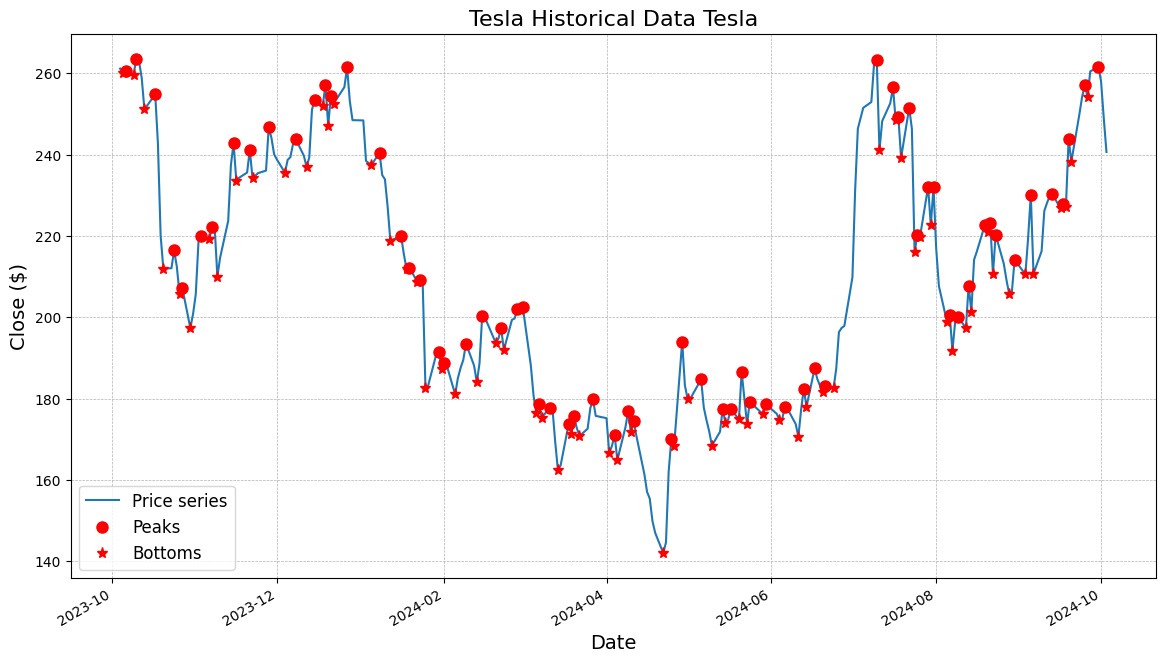

Peaks detected: [[260.53   2.  ]
 [263.62   4.  ]
 [254.85   9.  ]
 [216.52  14.  ]
 [207.3   17.  ]
 [219.96  22.  ]
 [222.18  24.  ]
 [242.84  30.  ]
 [241.2   34.  ]
 [246.72  38.  ]
 [243.84  46.  ]
 [253.5   51.  ]
 [257.22  53.  ]
 [254.5   55.  ]
 [261.44  58.  ]
 [240.45  65.  ]
 [219.91  70.  ]
 [212.19  73.  ]
 [209.14  75.  ]
 [191.59  80.  ]
 [188.86  82.  ]
 [193.57  88.  ]
 [200.45  92.  ]
 [197.41  96.  ]
 [202.04 100.  ]
 [202.64 102.  ]
 [178.65 106.  ]
 [177.77 108.  ]
 [173.8  113.  ]
 [175.66 115.  ]
 [179.83 120.  ]
 [171.11 125.  ]
 [176.88 128.  ]
 [174.6  130.  ]
 [170.18 140.  ]
 [194.05 142.  ]
 [184.76 147.  ]
 [177.55 153.  ]
 [177.46 156.  ]
 [186.6  158.  ]
 [179.24 161.  ]
 [178.79 164.  ]
 [177.94 169.  ]
 [182.47 174.  ]
 [187.44 176.  ]
 [183.01 179.  ]
 [263.26 191.  ]
 [256.56 195.  ]
 [249.23 197.  ]
 [251.51 199.  ]
 [220.25 202.  ]
 [232.1  204.  ]
 [232.07 206.  ]
 [200.64 210.  ]
 [200.   213.  ]
 [207.83 215.  ]
 [222.72 219.  ]
 [223.27 221.  

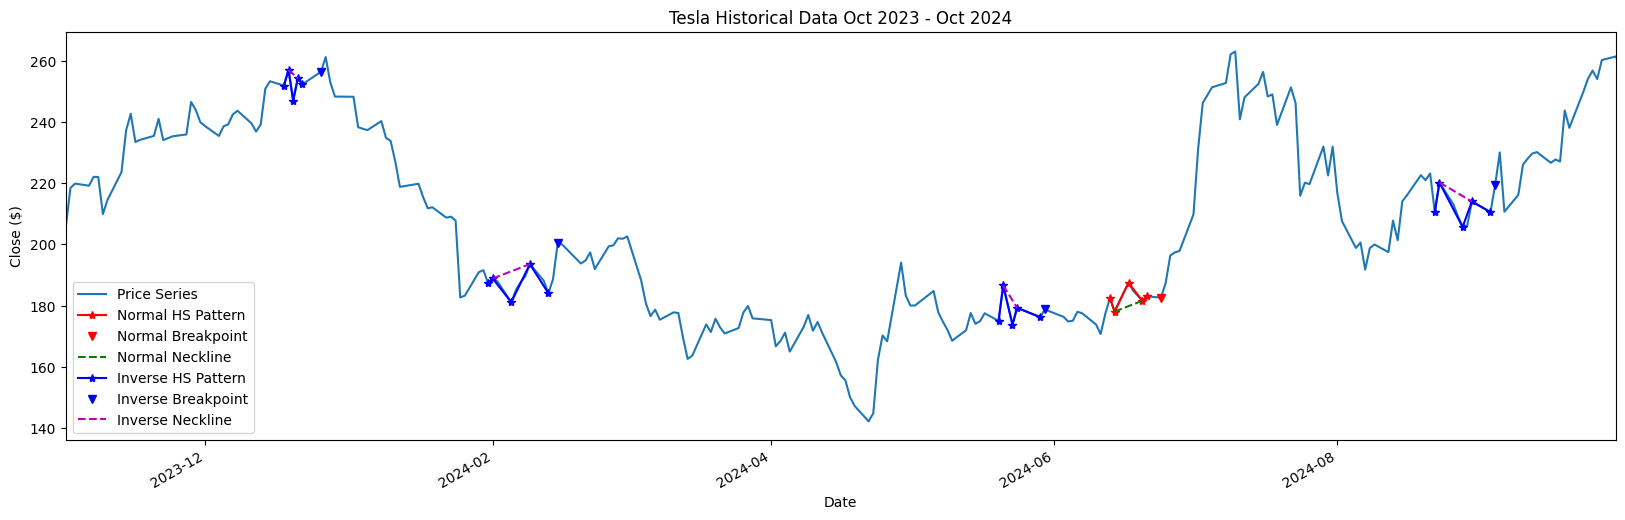

Identified Head and Shoulders Patterns (Normal Form): {'Points': [array([[174.  ,   1.  , 182.47],
       [175.  ,   2.  , 178.01],
       [176.  ,   1.  , 187.44],
       [178.  ,   2.  , 181.57],
       [179.  ,   1.  , 183.01]])], 'Necklines': [[-29.65666666666681, 1.1866666666666674]], 'Breakpoints': [[180.0, 182.58]], 'Widths': [3.0], 'Heights': [8.24333333333334], 'TL': [183.0], 'PT': [174.6992852233677], 'Numberofnormals': 1}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[ 52.  ,   2.  , 252.08],
       [ 53.  ,   1.  , 257.22],
       [ 54.  ,   2.  , 247.14],
       [ 55.  ,   1.  , 254.5 ],
       [ 56.  ,   2.  , 252.54]]), array([[ 81.  ,   2.  , 187.29],
       [ 82.  ,   1.  , 188.86],
       [ 84.  ,   2.  , 181.06],
       [ 88.  ,   1.  , 193.57],
       [ 90.  ,   2.  , 184.02]]), array([[157.  ,   2.  , 174.95],
       [158.  ,   1.  , 186.6 ],
       [160.  ,   2.  , 173.74],
       [161.  ,   1.  , 179.24],
       [163.  ,   2.  , 176.19

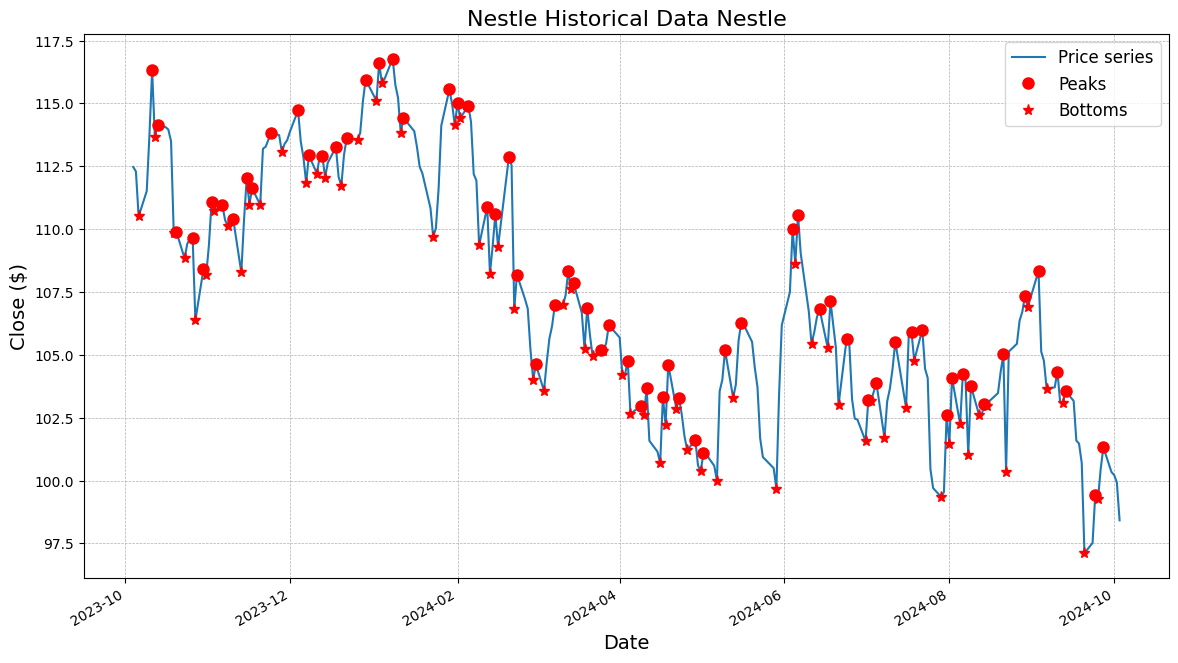

Peaks detected: [[116.324    5.    ]
 [114.138    7.    ]
 [109.884   12.    ]
 [109.634   16.    ]
 [108.414   18.    ]
 [111.08    21.    ]
 [110.95    23.    ]
 [110.396   27.    ]
 [112.022   30.    ]
 [111.6249  32.    ]
 [113.8315  36.    ]
 [114.72    42.    ]
 [112.93    46.    ]
 [112.91    49.    ]
 [113.26    52.    ]
 [113.615   56.    ]
 [115.95    60.    ]
 [116.618   62.    ]
 [116.785   65.    ]
 [114.43    69.    ]
 [115.558   79.    ]
 [115.01    82.    ]
 [114.91    84.    ]
 [110.89    89.    ]
 [110.6     92.    ]
 [112.855   94.    ]
 [108.19    97.    ]
 [104.618  102.    ]
 [106.97   107.    ]
 [108.35   110.    ]
 [107.848  112.    ]
 [106.87   115.    ]
 [105.194  118.    ]
 [106.18   121.    ]
 [104.77   125.    ]
 [102.954  128.    ]
 [103.68   130.    ]
 [103.33   134.    ]
 [104.608  136.    ]
 [103.286  138.    ]
 [101.61   142.    ]
 [101.08   145.    ]
 [105.18   151.    ]
 [106.286  155.    ]
 [109.99   167.    ]
 [110.58   169.    ]
 [106.808  175.   

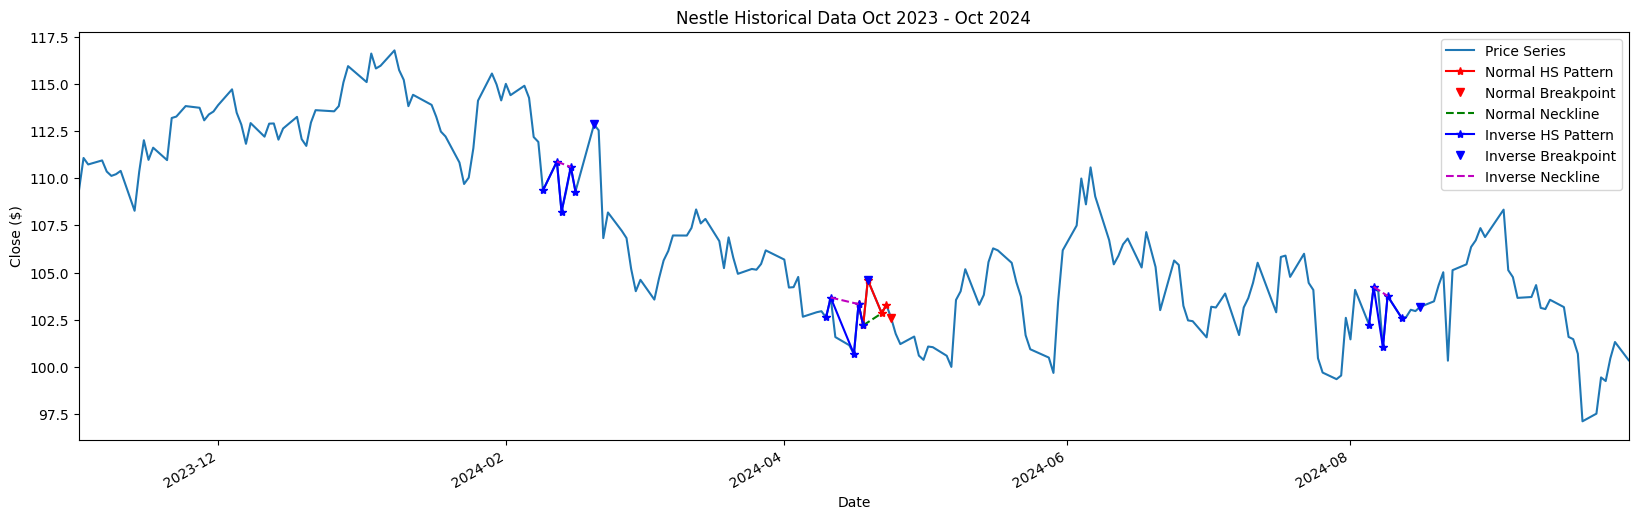

Identified Head and Shoulders Patterns (Normal Form): {'Points': [array([[134.   ,   1.   , 103.33 ],
       [135.   ,   2.   , 102.205],
       [136.   ,   1.   , 104.608],
       [137.   ,   2.   , 102.845],
       [138.   ,   1.   , 103.286]])], 'Necklines': [[59.00499999999996, 0.3200000000000003]], 'Breakpoints': [[139.0, 102.6158]], 'Widths': [2.0], 'Heights': [2.0829999999999984], 'TL': [141.0], 'PT': [101.12110321147243], 'Numberofnormals': 1}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[ 88.  ,   2.  , 109.36],
       [ 89.  ,   1.  , 110.89],
       [ 90.  ,   2.  , 108.23],
       [ 92.  ,   1.  , 110.6 ],
       [ 93.  ,   2.  , 109.3 ]]), array([[129.   ,   2.   , 102.62 ],
       [130.   ,   1.   , 103.68 ],
       [133.   ,   2.   , 100.688],
       [134.   ,   1.   , 103.33 ],
       [135.   ,   2.   , 102.205]]), array([[209.    ,   2.    , 102.2456],
       [210.    ,   1.    , 104.25  ],
       [212.    ,   2.    , 101.03  ],
       [213

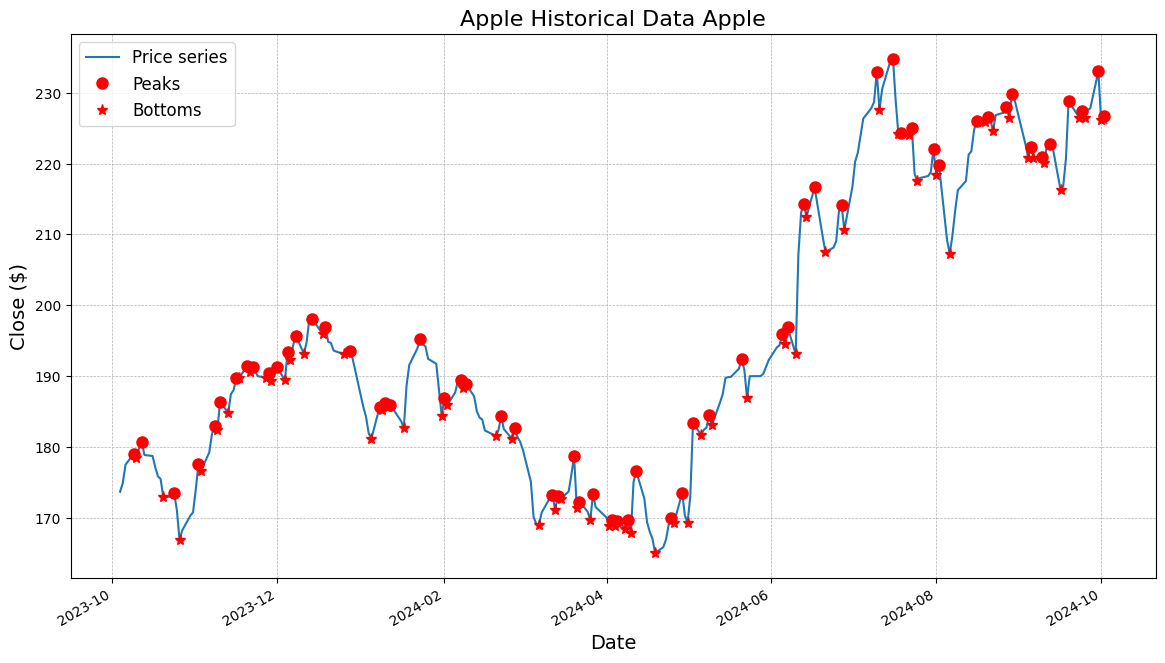

Peaks detected: [[178.99   3.  ]
 [180.71   6.  ]
 [173.44  14.  ]
 [177.57  21.  ]
 [182.89  25.  ]
 [186.4   27.  ]
 [189.71  31.  ]
 [191.45  33.  ]
 [191.31  35.  ]
 [190.4   38.  ]
 [191.24  41.  ]
 [193.42  43.  ]
 [195.71  46.  ]
 [198.11  50.  ]
 [196.94  53.  ]
 [193.58  59.  ]
 [185.56  65.  ]
 [186.19  67.  ]
 [185.92  69.  ]
 [195.18  75.  ]
 [186.86  82.  ]
 [189.41  86.  ]
 [188.85  88.  ]
 [184.37  96.  ]
 [182.63  99.  ]
 [173.23 109.  ]
 [173.   111.  ]
 [178.67 115.  ]
 [172.28 117.  ]
 [173.31 120.  ]
 [169.65 124.  ]
 [169.58 126.  ]
 [169.67 128.  ]
 [176.55 131.  ]
 [169.89 140.  ]
 [173.5  142.  ]
 [183.38 146.  ]
 [184.57 150.  ]
 [192.35 158.  ]
 [195.87 168.  ]
 [196.89 170.  ]
 [214.24 174.  ]
 [216.67 176.  ]
 [214.1  183.  ]
 [232.98 191.  ]
 [234.82 195.  ]
 [224.31 198.  ]
 [225.01 200.  ]
 [222.08 206.  ]
 [219.86 208.  ]
 [226.05 218.  ]
 [226.51 220.  ]
 [228.03 225.  ]
 [229.79 227.  ]
 [222.38 231.  ]
 [220.91 233.  ]
 [222.77 236.  ]
 [228.87 241.  

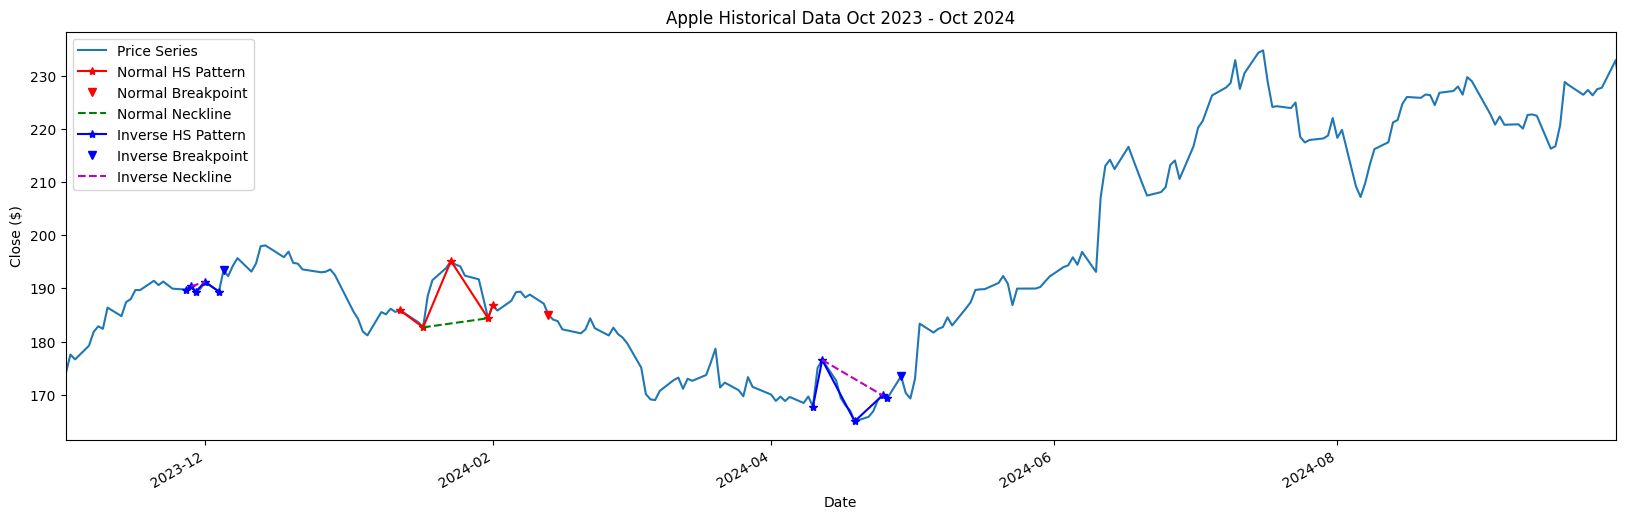

Identified Head and Shoulders Patterns (Normal Form): {'Points': [array([[ 69.  ,   1.  , 185.92],
       [ 71.  ,   2.  , 182.68],
       [ 75.  ,   1.  , 195.18],
       [ 81.  ,   2.  , 184.4 ],
       [ 82.  ,   1.  , 186.86]])], 'Necklines': [[170.46800000000002, 0.17199999999999988]], 'Breakpoints': [[90.0, 185.04]], 'Widths': [10.0], 'Heights': [11.812000000000012], 'TL': [100.0], 'PT': [174.06756178790533], 'Numberofnormals': 1}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[ 37.  ,   2.  , 189.79],
       [ 38.  ,   1.  , 190.4 ],
       [ 39.  ,   2.  , 189.37],
       [ 41.  ,   1.  , 191.24],
       [ 42.  ,   2.  , 189.43]]), array([[129.  ,   2.  , 167.78],
       [131.  ,   1.  , 176.55],
       [136.  ,   2.  , 165.  ],
       [140.  ,   1.  , 169.89],
       [141.  ,   2.  , 169.3 ]])], 'Necklines': [[179.75999999999996, 0.28000000000000114], [273.49000000000035, -0.7400000000000028]], 'Breakpoints': [[43.0, 193.42], [142.0, 173.5]], 'Widths

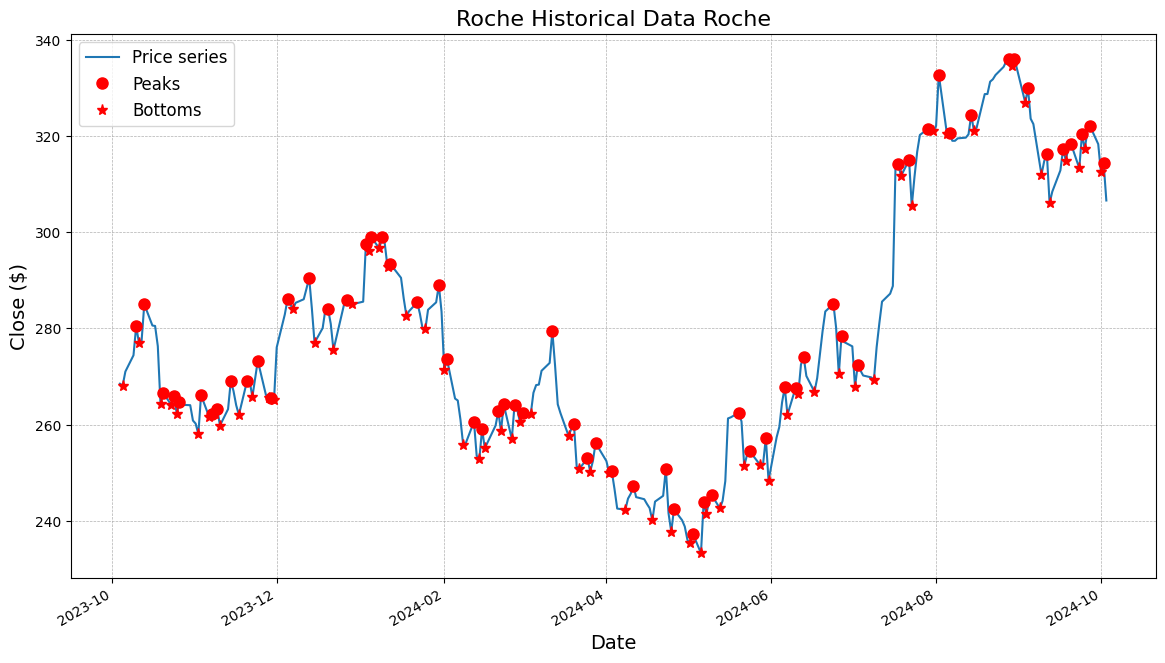

Peaks detected: [[280.44   4.  ]
 [285.     7.  ]
 [266.6   12.  ]
 [266.    14.  ]
 [264.68  16.  ]
 [266.11  22.  ]
 [262.28  24.  ]
 [263.24  26.  ]
 [269.    29.  ]
 [269.    33.  ]
 [273.27  36.  ]
 [265.59  39.  ]
 [286.    43.  ]
 [290.5   49.  ]
 [284.    54.  ]
 [285.8   58.  ]
 [297.5   62.  ]
 [298.93  64.  ]
 [298.96  66.  ]
 [293.41  69.  ]
 [285.39  74.  ]
 [289.    80.  ]
 [273.6   83.  ]
 [260.58  89.  ]
 [259.09  92.  ]
 [262.75  95.  ]
 [264.18  97.  ]
 [264.02  99.  ]
 [262.5  102.  ]
 [279.39 109.  ]
 [260.02 115.  ]
 [252.96 118.  ]
 [256.16 121.  ]
 [250.24 124.  ]
 [247.3  130.  ]
 [250.79 138.  ]
 [242.36 141.  ]
 [237.29 146.  ]
 [244.   148.  ]
 [245.3  151.  ]
 [262.44 157.  ]
 [254.46 161.  ]
 [257.2  164.  ]
 [267.78 169.  ]
 [267.6  171.  ]
 [274.01 174.  ]
 [285.08 180.  ]
 [278.4  183.  ]
 [272.33 187.  ]
 [314.25 197.  ]
 [315.   199.  ]
 [321.47 204.  ]
 [332.73 208.  ]
 [320.64 210.  ]
 [324.35 216.  ]
 [336.   226.  ]
 [336.07 228.  ]
 [329.98 230.  

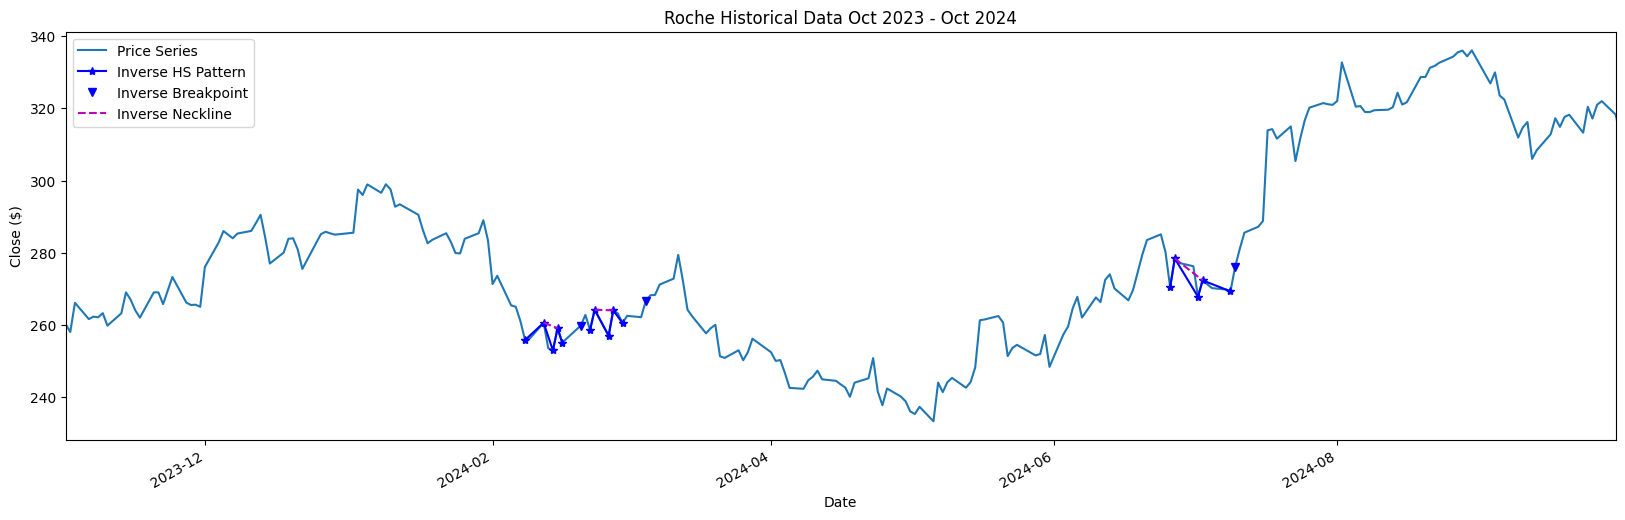

Identified Head and Shoulders Patterns (Normal Form): {'Points': [], 'Necklines': [], 'Breakpoints': [], 'Widths': [], 'Heights': [], 'TL': [], 'PT': [], 'Numberofnormals': 0}
Identified Head and Shoulders Patterns (Inverse Form): {'Points': [array([[ 87.  ,   2.  , 255.79],
       [ 89.  ,   1.  , 260.58],
       [ 91.  ,   2.  , 252.91],
       [ 92.  ,   1.  , 259.09],
       [ 93.  ,   2.  , 255.06]]), array([[ 96.  ,   2.  , 258.59],
       [ 97.  ,   1.  , 264.18],
       [ 98.  ,   2.  , 257.  ],
       [ 99.  ,   1.  , 264.02],
       [101.  ,   2.  , 260.5 ]]), array([[182.  ,   2.  , 270.43],
       [183.  ,   1.  , 278.4 ],
       [186.  ,   2.  , 267.8 ],
       [187.  ,   1.  , 272.33],
       [190.  ,   2.  , 269.29]])], 'Necklines': [[304.7833333333336, -0.4966666666666697], [271.9400000000012, -0.0800000000000125], [556.1024999999997, -1.5174999999999983]], 'Breakpoints': [[94.0, 259.8], [104.0, 266.6], [191.0, 276.07]], 'Widths': [3.0, 2.0, 4.0], 'Heights': [6.67666666

In [ ]:
#Use real data
def head_and_shoulder(file_path, stock_name):
    w = 1  # Rolling window size
    pflag = 1  # Set to 1 to plot the series
    data = pd.read_csv(file_path)
    price = data["Close"]
    date = data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
    patterns = hs_pattern(price, w, pflag, date, stock_name)
    # Print the result
    print("Identified Head and Shoulders Patterns (Normal Form):", patterns['NORMAL'])
    print("Identified Head and Shoulders Patterns (Inverse Form):", patterns['INVERSE'])

head_and_shoulder(file_path_tesla, "Tesla")
head_and_shoulder(file_path_nestle, "Nestle")
head_and_shoulder(file_path_apple, "Apple")
head_and_shoulder(file_path_roche, "Roche")

Source:
Tesla: https://www.nasdaq.com/market-activity/stocks/tsla/historical?page=1&rows_per_page=10&timeline=y1

Apple: https://www.nasdaq.com/market-activity/stocks/aapl/historical?page=1&rows_per_page=10&timeline=y1

Nestle: https://www.nasdaq.com/market-activity/stocks/nsrgf/historical?page=1&rows_per_page=10&timeline=y1

Roche: https://www.nasdaq.com/market-activity/stocks/rhhvf/historical?page=1&rows_per_page=10&timeline=y1